Выполнить предсказание временного ряда. Разделить данные нужно не смешивая прошлое и будущее. Использовать Electric_Production.
Использовать sarima / Prophet.
Docker / собрать контейнер с tf + добавить свои данные.

In [1]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from prophet.diagnostics import cross_validation, performance_metrics
from prophet import Prophet

from hyperopt import hp, Trials, fmin, partial, STATUS_OK

import seaborn as sb
import pandas as pd

import hyperopt


In [2]:
csv_file = 'Electric_Production.csv'
electric_df = pd.read_csv(csv_file)
electric_df


,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [3]:
electric_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


В таблице с данными пропусков нет, в столбце Data хранятся строки, поэтому приводим столбец к соответствующему типу, визуализируем временной ряд.

In [4]:
# convert values from DATE column to datetime type
electric_df['DATE'] = pd.to_datetime(electric_df['DATE'])
electric_df = electric_df.sort_values(by='DATE')
electric_df


,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


[Text(0.5, 1.0, 'Time series')]

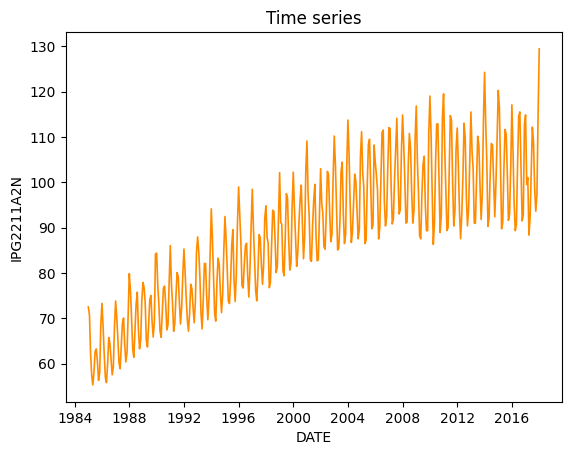

In [5]:
# visualize time series
sb.lineplot(data=electric_df, x='DATE', y='IPG2211A2N', color='darkorange', lw=1.2).set(title='Time series')


Подберем параметры order и seasonal_order для модели SARIMAX, обучим модель с данными параметрами и получим предсказание.

In [6]:
# split dataset into train and test
split_ratio = int(0.8 * len(electric_df))

train_df = electric_df[:split_ratio].copy()
test_df = electric_df[split_ratio:].copy()

print(len(train_df), len(test_df))


317 80


In [7]:
# find best params for SARIMAX model with auto_arima
arima_best = auto_arima(train_df['IPG2211A2N'], start_p=0, start_q=0, m=12, seasonal=True, stationary=False)
arima_best.get_params()


{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 0, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 1, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [ ]:
# create SARIMAX model with best parameters, fit it, get predict
sarima_model = SARIMAX(train_df['IPG2211A2N'], order=arima_best.get_params()['order'], 
                       seasonal_order=arima_best.get_params()['seasonal_order'])
results = sarima_model.fit()
sarima_pred = results.get_forecast(steps=len(test_df)).predicted_mean


[Text(0.5, 1.0, 'SARIMAX prediction')]

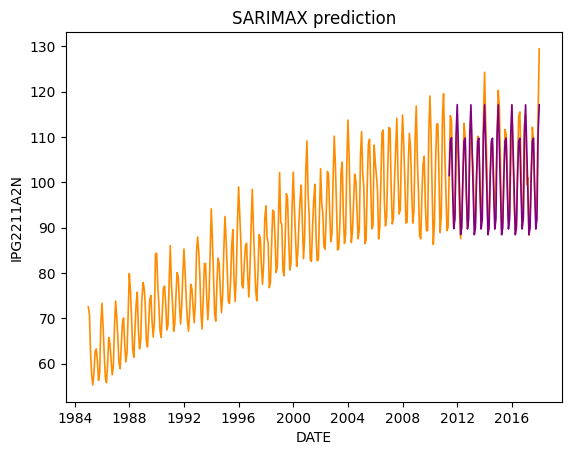

In [11]:
# visualize SARIMAX predicted time series
sb.lineplot(data=electric_df, x='DATE', y='IPG2211A2N', color='darkorange', lw=1.2)
sb.lineplot(x=test_df['DATE'], y=sarima_pred, color='purple', lw=1.2).set(title='SARIMAX prediction')


In [12]:
# calculate RMSE and MAE metrics
sarima_rmse = root_mean_squared_error(test_df['IPG2211A2N'], sarima_pred)
sarima_mae = mean_absolute_error(test_df['IPG2211A2N'], sarima_pred)

print('Root Mean Squared Error:', sarima_rmse)
print('Mean Absolute Error:', sarima_mae) 
print('Average IPG2211A2N test set value:', test_df['IPG2211A2N'].mean())


Root Mean Squared Error: 3.71918785757149
Mean Absolute Error: 2.8741475827825775
Average IPG2211A2N test set value: 102.71854125


По значениям метрик видно, что ошибки (rmse, mae) значительно меньше среднего значения в тестовой выборке, следовательно, модель работает удовлетворительно.

Prophet

Подбираем наилучшие параметры для модели Prophet, обучаем и получам прогноз.

In [13]:
# renamne columns for Prophet
prophet_cols = ['ds', 'y']
train_df.columns = prophet_cols
test_df.columns = prophet_cols


In [14]:
# function for shoose model parameters
def objective(params, x):
    model = Prophet(seasonality_mode='multiplicative', 
                    changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale=params['seasonality_prior_scale'])
    model = model.fit(x)

    cv_preds = cross_validation(model, horizon='365 days', parallel='processes')
    cv_scores = performance_metrics(cv_preds, rolling_window=1)

    return {'loss': cv_scores['rmse'], 'params': params, 'status': STATUS_OK}


In [15]:
# initialize parametrs for choose
params = {'changepoint_prior_scale': hp.choice(label='changepoint_prior_scale', 
                                               options=[0.001, 0.01, 0.1, 0.5]),
          'seasonality_prior_scale': hp.choice(label='seasonality_prior_scale', 
                                               options=[0.01, 0.1, 1., 10.])}


In [ ]:
trials = Trials()
best = fmin(fn=partial(objective, x=test_df), space=params, algo=hyperopt.tpe.suggest, 
            max_evals=50, trials=trials, verbose=False)
best_params = hyperopt.space_eval(params, best)


In [17]:
best_params


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}

In [ ]:
# create and fit Prophet model with best params
prophet_model = Prophet(seasonality_mode='multiplicative', 
                        changepoint_prior_scale=best_params['changepoint_prior_scale'],
                        seasonality_prior_scale=best_params['seasonality_prior_scale'])
prophet_model = prophet_model.fit(train_df)


In [42]:
prophet_pred = prophet_model.predict(test_df)[['ds', 'yhat']]
prophet_pred


,ds,yhat
0,2011-06-01,105.386586
1,2011-07-01,114.669751
2,2011-08-01,115.862839
3,2011-09-01,104.349727
4,2011-10-01,96.777549
...,...,...
75,2017-09-01,114.175634
76,2017-10-01,106.171145
77,2017-11-01,109.679750
78,2017-12-01,126.823808


[Text(0.5, 1.0, 'Prophet prediction')]

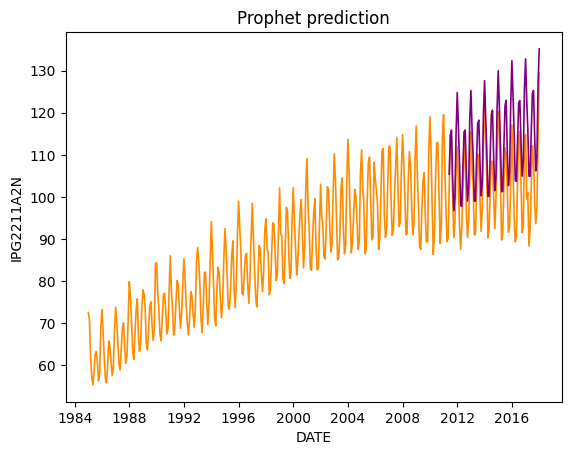

In [43]:
# visualize Prophet predicted time series
sb.lineplot(data=electric_df, x='DATE', y='IPG2211A2N', color='darkorange', lw=1.2)
sb.lineplot(data=prophet_pred, x='ds', y='yhat', color='purple', lw=1.2).set(title='Prophet prediction')


In [44]:
# calculate RMSE and MAE metrics
prophet_rmse = root_mean_squared_error(test_df['y'], prophet_pred['yhat'])
prophet_mae = mean_absolute_error(test_df['y'], prophet_pred['yhat'])

print('Root Mean Squared Error:', prophet_rmse)
print('Mean Absolute Error:', prophet_mae) 
print('Average IPG2211A2N test set value:', test_df['y'].mean())


Root Mean Squared Error: 10.969889463469597
Mean Absolute Error: 10.099818506211673
Average IPG2211A2N test set value: 102.71854125


<Axes: title={'center': 'Comparison predictions'}, xlabel='DATE', ylabel='IPG2211A2N'>

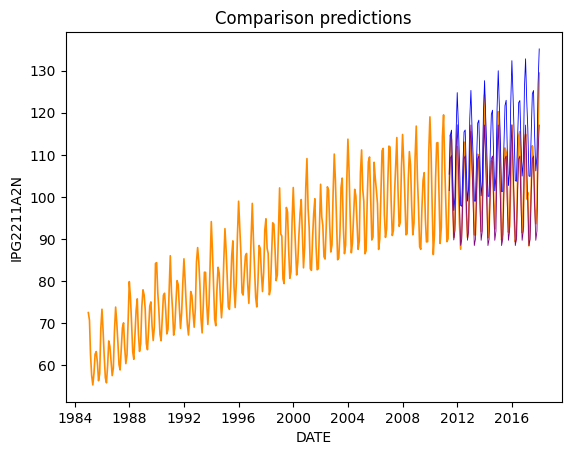

In [41]:
# visualize SARIMAX and Prophet predicted time series
sb.lineplot(data=electric_df, x='DATE', y='IPG2211A2N', color='darkorange', lw=1.2).set(title='Comparison predictions')
sb.lineplot(x=test_df['ds'], y=sarima_pred, color='purple', lw=0.6)
sb.lineplot(data=prophet_pred, x='ds', y='yhat', color='blue', lw=0.6)


Как видно из метрик и сравнительного графика, SARIMAX обеспечивает большую точность предсказания и почти совпадает с тестовым набором данных на графике.